# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/500000.h5ad")
adata.var_names_make_unique()

CPU times: user 566 ms, sys: 5.36 s, total: 5.93 s
Wall time: 15.8 s


In [5]:
adata.shape

(500000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 2.01 s, sys: 2.12 s, total: 4.13 s
Wall time: 4.3 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(500000, 27998)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

1018936313

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 20.12578272819519


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 5.25 ms, sys: 466 µs, total: 5.71 ms
Wall time: 5.56 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(cudata,qc_vars=["MT"])

CPU times: user 150 ms, sys: 11 ms, total: 161 ms
Wall time: 230 ms


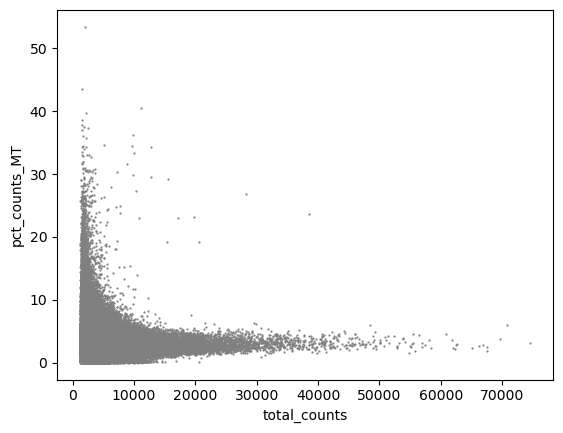

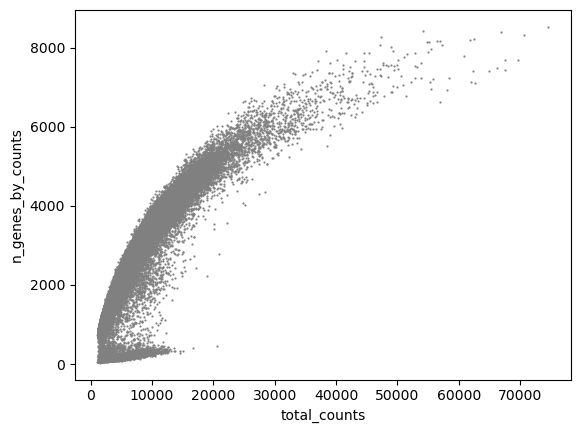

In [13]:
rsc.pl.scatter(cudata,"total_counts","pct_counts_MT")
rsc.pl.scatter(cudata,"total_counts","n_genes_by_counts")

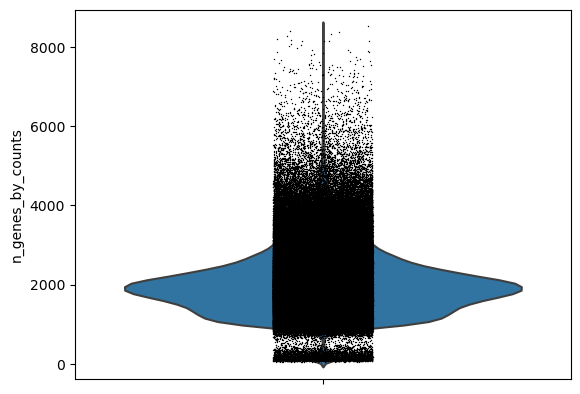

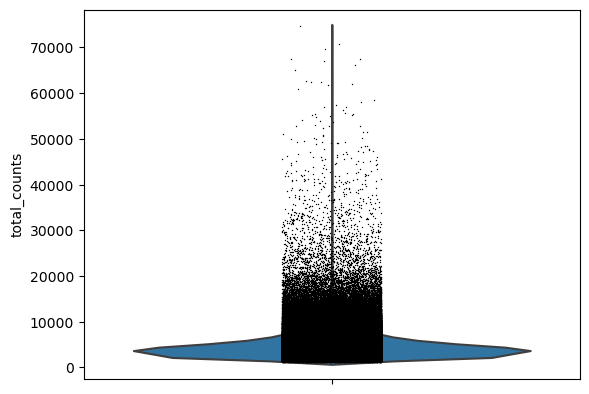

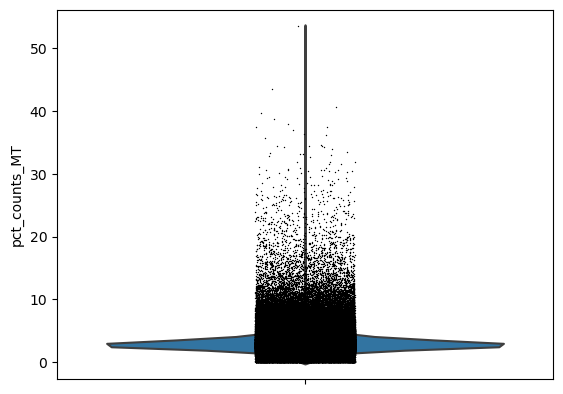

In [14]:
rsc.pl.violin(cudata,key="n_genes_by_counts")
rsc.pl.violin(cudata,key="total_counts")
rsc.pl.violin(cudata,key="pct_counts_MT")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
cudata = cudata[cudata.obs["n_genes_by_counts"] < 5000]
cudata = cudata[cudata.obs["n_genes_by_counts"] > 500]

cudata.shape

CPU times: user 186 ms, sys: 83.2 ms, total: 270 ms
Wall time: 287 ms


(492660, 27998)

In [16]:
%%time
cudata = cudata[cudata.obs["pct_counts_MT"] < 20]
cudata.shape

CPU times: user 46.4 ms, sys: 26.7 ms, total: 73.1 ms
Wall time: 72.5 ms


(492376, 27998)

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 6139 genes based on n_cells_by_counts
CPU times: user 373 ms, sys: 797 ms, total: 1.17 s
Wall time: 1.72 s


In [18]:
cudata.layers["counts"] = cudata.X.copy()

In [19]:
cudata.shape

(492376, 21859)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 183 µs, sys: 399 µs, total: 582 µs
Wall time: 2.97 ms


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 21.6 ms, sys: 10.5 ms, total: 32.1 ms
Wall time: 45.3 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",layer = "counts")

CPU times: user 1.11 s, sys: 2.46 s, total: 3.57 s
Wall time: 1.11 s


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [23]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 1.71 s, sys: 956 ms, total: 2.66 s
Wall time: 2.67 s


Now we restrict our cunndata object to the highly variable genes.

In [24]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 455 ms, sys: 91.1 ms, total: 546 ms
Wall time: 549 ms


In [25]:
cudata.shape

(492376, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(cudata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 2.33 s, sys: 1.99 s, total: 4.32 s
Wall time: 4.79 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 249 ms, sys: 717 ms, total: 965 ms
Wall time: 1.61 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `cunndata_funcs` that uses cuMLs PCA to run this.

In [28]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 2.6 s, sys: 132 ms, total: 2.73 s
Wall time: 3.2 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

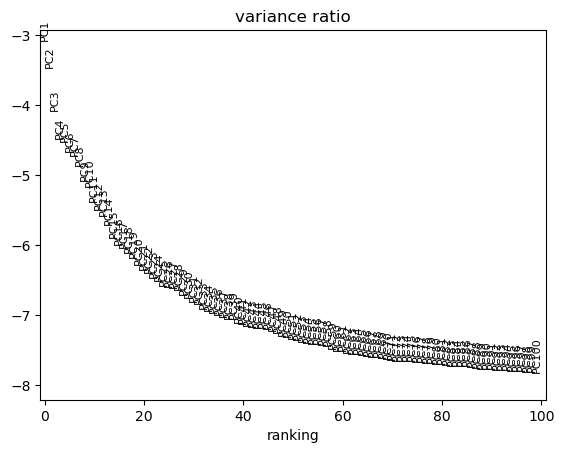

In [29]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [30]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 1.3 s, sys: 768 ms, total: 2.07 s
Wall time: 2.08 s


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 24.72308874130249


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [32]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=60, method='rapids')

CPU times: user 16.7 s, sys: 685 ms, total: 17.4 s
Wall time: 17 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [33]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 6.42 s, sys: 61 ms, total: 6.48 s
Wall time: 6.58 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [34]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 913 ms, sys: 2.18 s, total: 3.09 s
Wall time: 3.47 s


In [35]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 495 ms, sys: 110 ms, total: 605 ms
Wall time: 606 ms


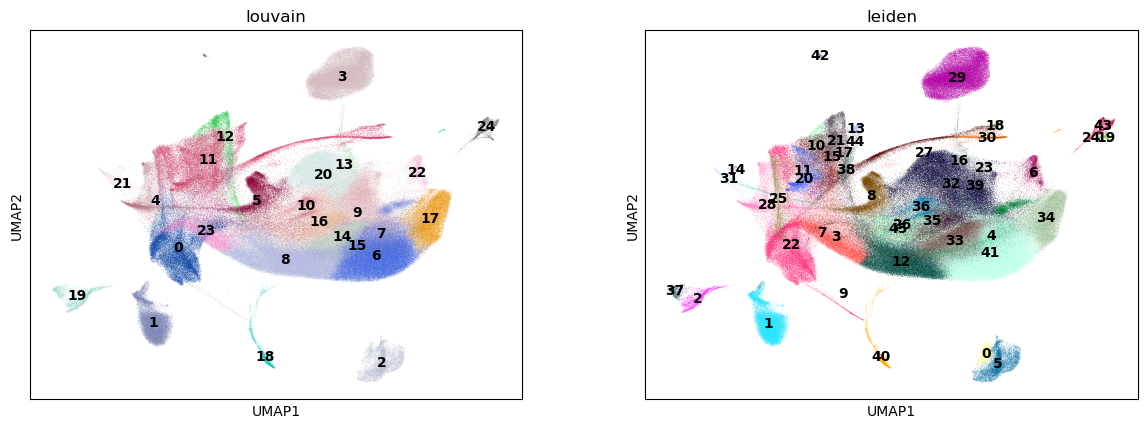

CPU times: user 2.79 s, sys: 165 ms, total: 2.95 s
Wall time: 2.78 s


In [36]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

We also caluclate the embedding density in the UMAP using cuML

## TSNE

In [37]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [13:54:03.597675] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 7.35 s, sys: 5.79 s, total: 13.1 s
Wall time: 13.3 s


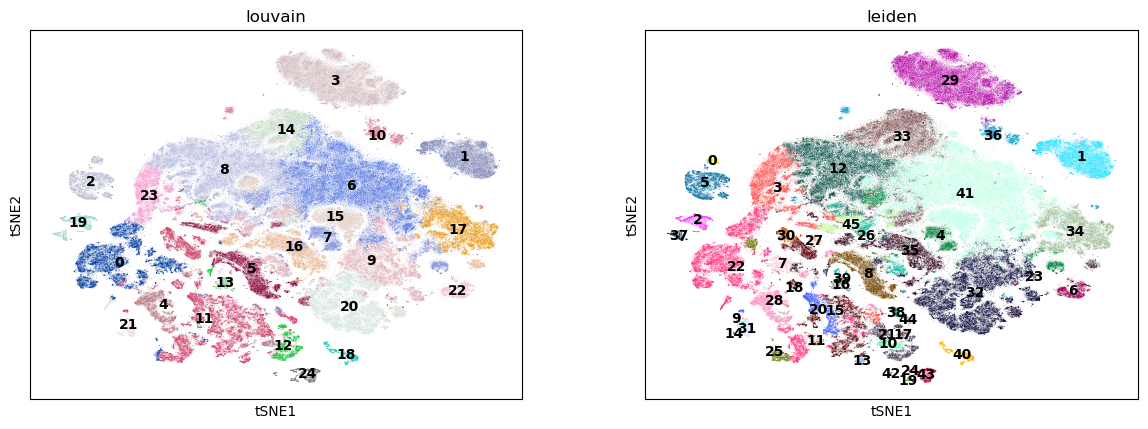

In [38]:
sc.pl.tsne(adata,color=["louvain","leiden"], legend_loc='on data')

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [39]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [13:54:47.987623] L-BFGS: max iterations reached
[W] [13:54:47.988065] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 19.9 s, sys: 8.59 s, total: 28.5 s
Wall time: 28.6 s


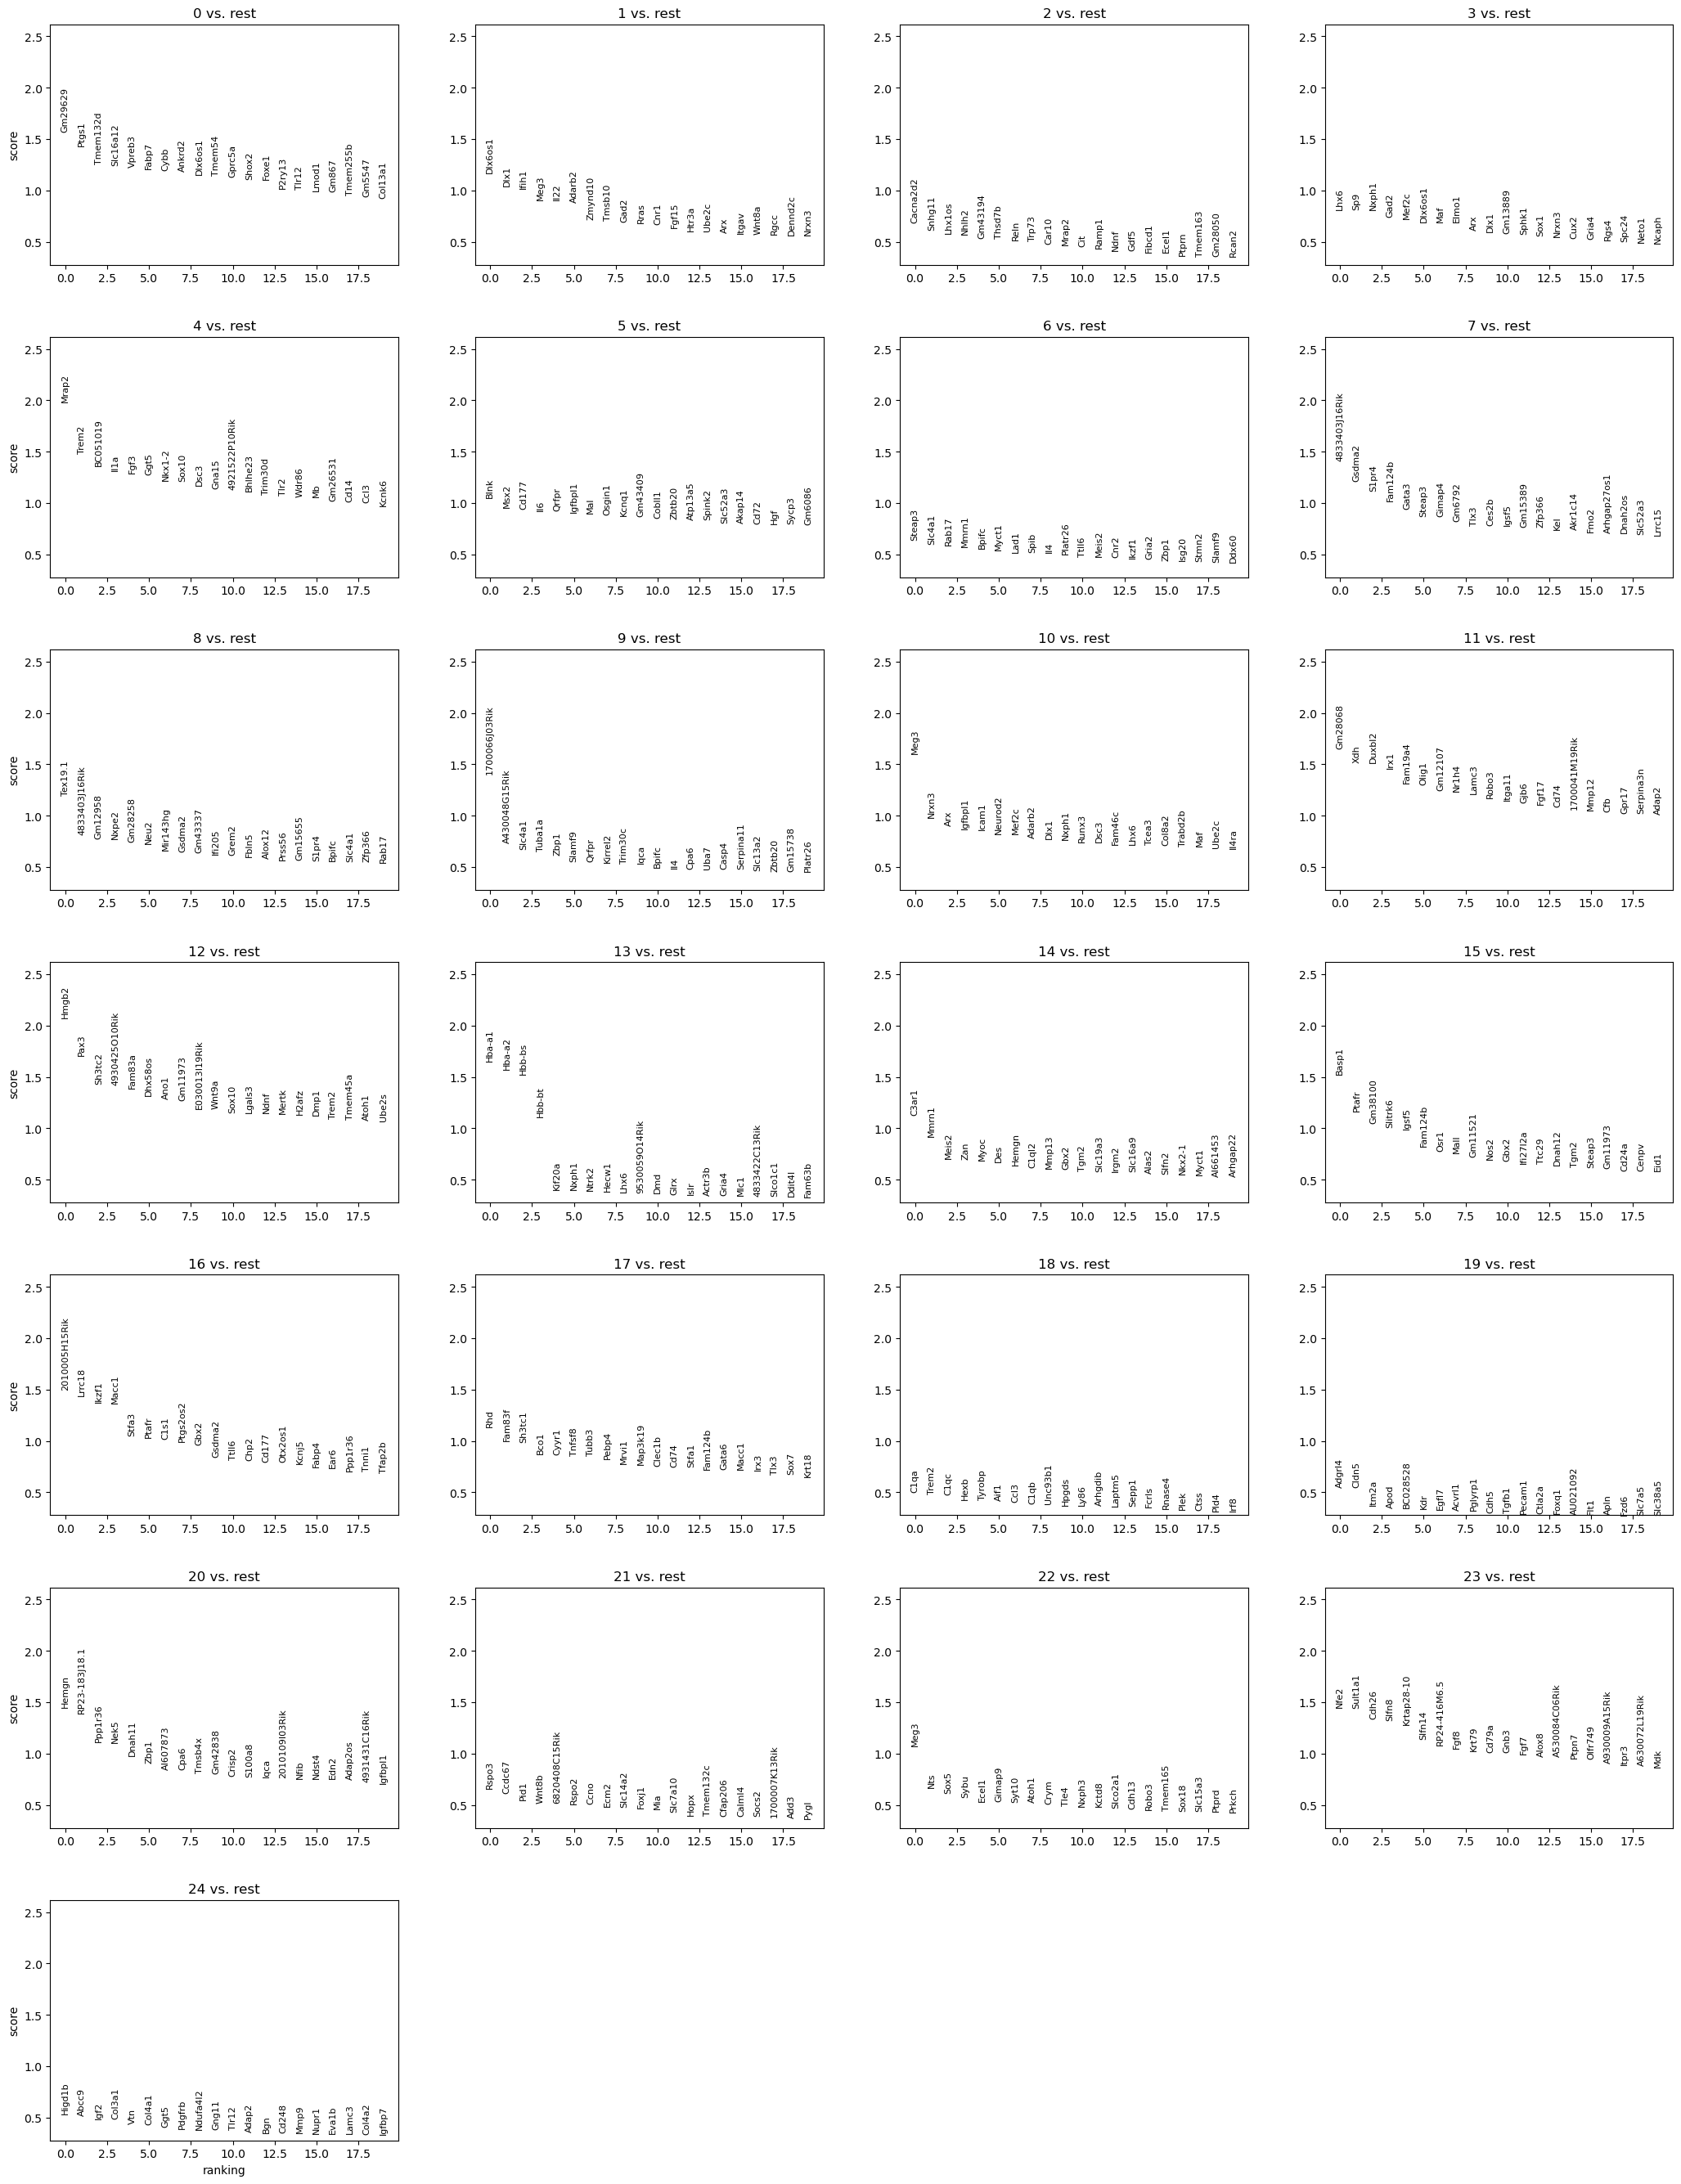

CPU times: user 2.67 s, sys: 205 ms, total: 2.88 s
Wall time: 2.7 s


In [40]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [41]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:] 

CPU times: user 1.86 s, sys: 6.83 s, total: 8.69 s
Wall time: 848 ms


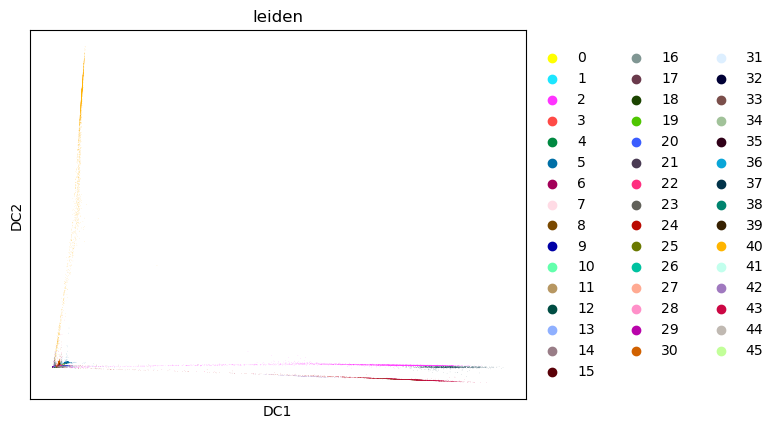

In [42]:
sc.pl.diffmap(adata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [43]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 105.4256477355957
